In [1]:
from torchvision import datasets
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Download and import the training data.
data_folder = '~/Documents/Projects/PyTorch/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [2]:
# Download and import the validation data
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [3]:
# Import the needed packages.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Learning Rate on Scaled Dataset

## High Learning Rate

In [21]:
# Build a class that fetches the dataset.
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

# Define the model, optimizer and loss function.
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-1) # Set learning rate to 0.1
    return model, loss_fn, optimizer

# Function to train the dataset on a batch of images.
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

# Function to calculate the accuracy of a given dataset.
def accuracy(x, y, model):
    model.eval()
    # this is the same as @torch.no_grad 
    # at the top of function, only difference
    # being, grad is not computed in the with scope
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [22]:
# Function that generates a training DataLoader from the dataset.
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [23]:
# Calculate the loss of the validation data.
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [24]:
# Initialize the model, loss function and optimizer.
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [25]:
# Initialize the lists containing the training and validation accuracy as well as loss value over increasing epochs.
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


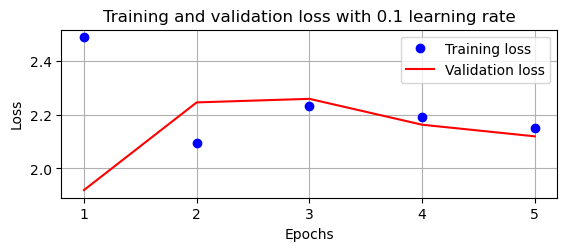

C:\Users\jilla\AppData\Local\Temp\ipykernel_11940\2651813370.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


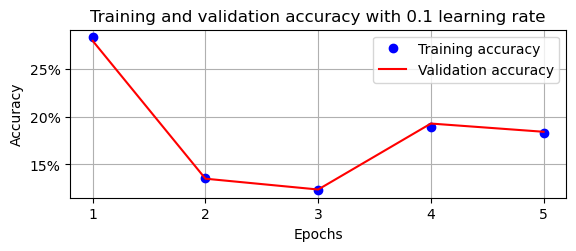

In [26]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

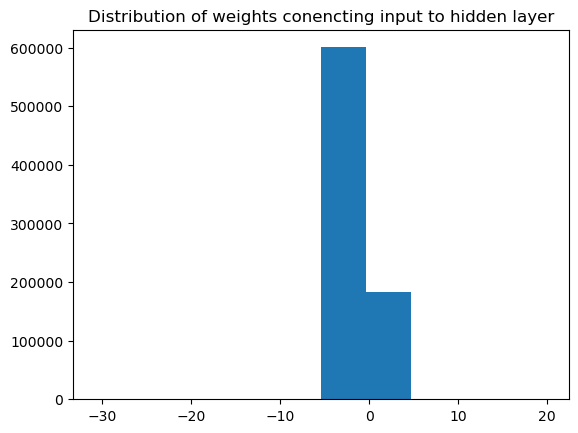

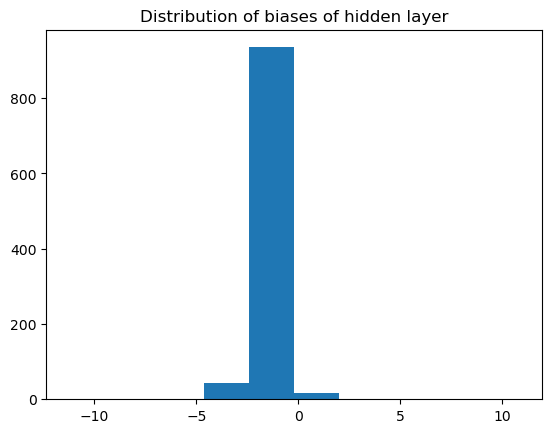

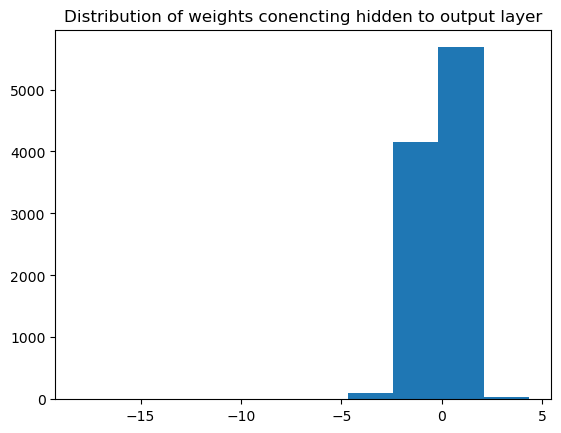

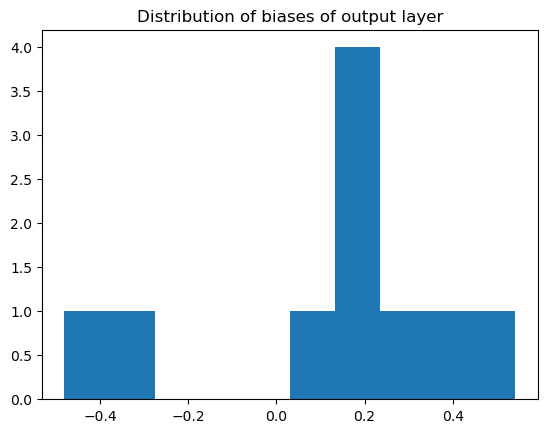

In [27]:
# Plot the accuracy and loss values in the training and validation datasets over increasing epochs.
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

The accuracy of the validation data was drastically reduced in comparison to the 85% accuracy in the model created with a learning rate of 0.01.

## Medium Learning Rate

In [28]:
# Define the model, optimizer and loss function.
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3) # Set learning rate to 0.001
    return model, loss_fn, optimizer

In [29]:
# Initialize the model, loss function and optimizer.
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [30]:
# Initialize the lists containing the training and validation accuracy as well as loss value over increasing epochs.
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


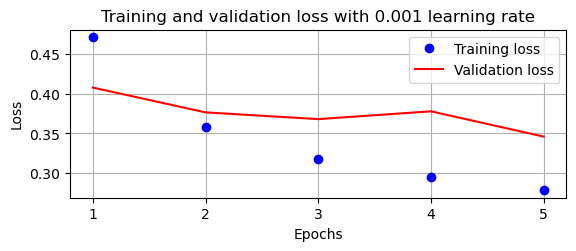

C:\Users\jilla\AppData\Local\Temp\ipykernel_11940\1288114839.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


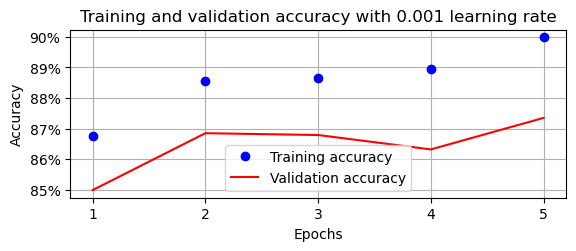

In [31]:
# Plot the accuracy and loss values in the training and validation datasets over increasing epochs.
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

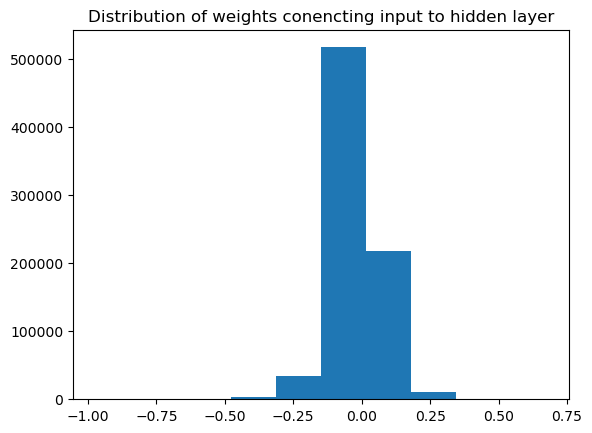

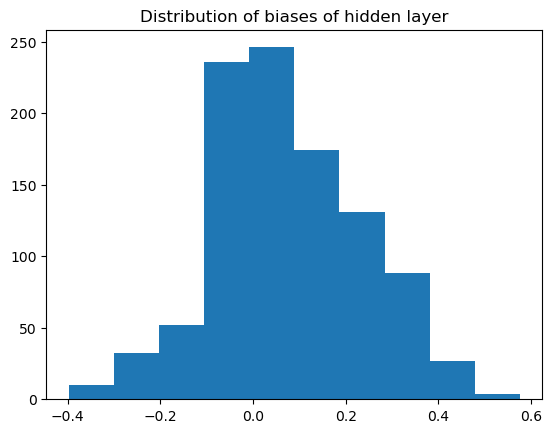

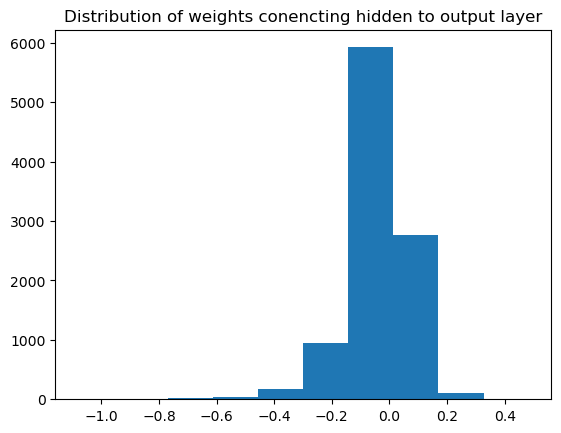

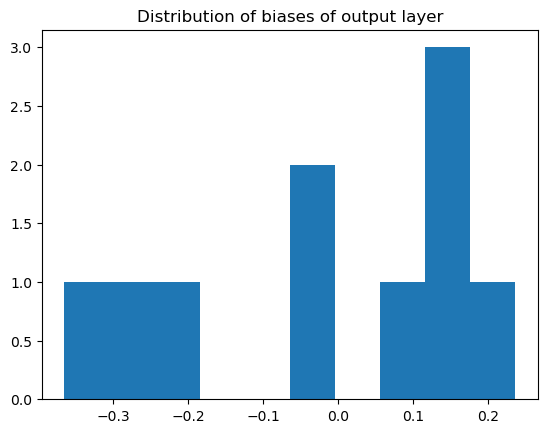

In [32]:
# Plot the distribution of weights connecting the input and hidden layers.
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

With the lower learning rate, the accuracy of the model increased.

## Low Learning Rate

In [33]:
# Define the model, optimizer and loss function.
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-5) # Set learning rate to 0.00001
    return model, loss_fn, optimizer 

In [34]:
# Initialize the model, loss function and optimizer.
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [35]:
# Initialize the lists containing the training and validation accuracy as well as loss value over increasing epochs.
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


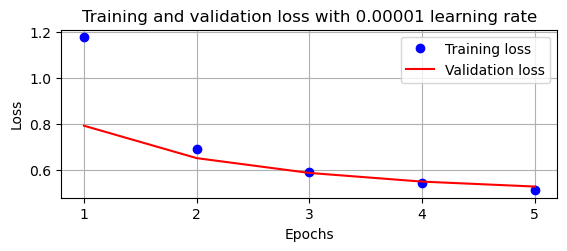

C:\Users\jilla\AppData\Local\Temp\ipykernel_11940\3738980992.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


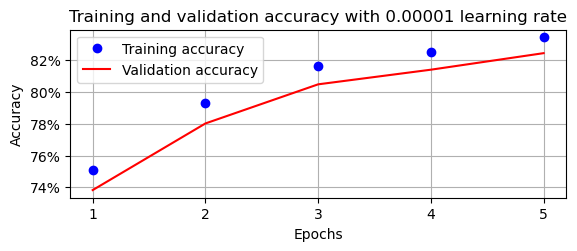

In [36]:
# Plot the accuracy and loss values in the training and validation datasets over increasing epochs.
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

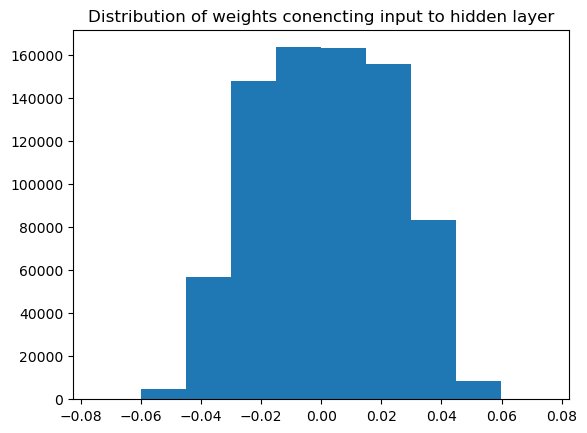

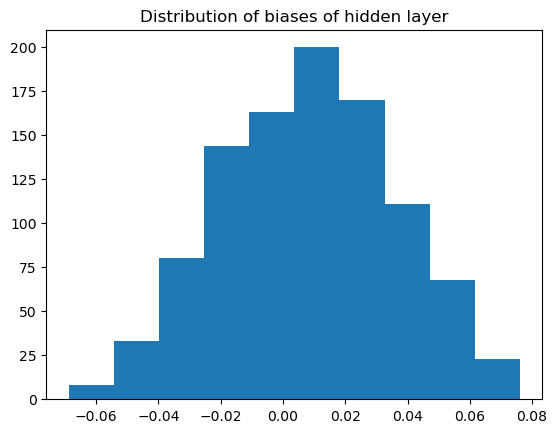

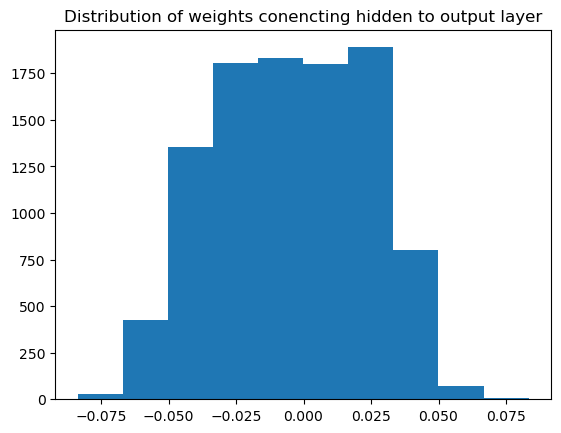

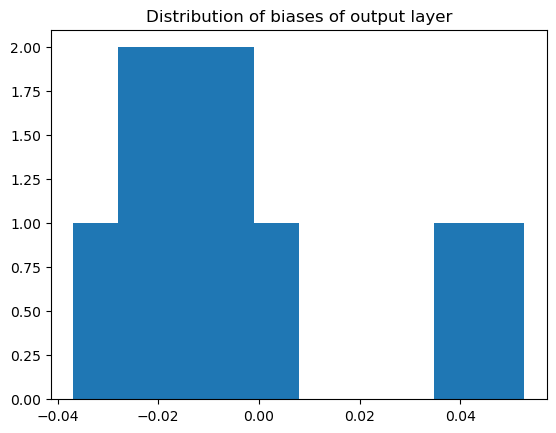

In [37]:
# Plot the distribution of weights connecting the input and hidden layers.
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

With the learning rate being so low, the model takes longer to achieve an acceptable accuracy. It would take 100 epochs to obtain an 89% accuracy at this learning rate in comparison to 8 epochs at a learning rate of 0.001 to achieve the same. The weight update is much lower when the learning rate is lower, so the gap between the validation and training loss does not widen as fast.

When reviewing the parameter distribution across the layers for the varying learning rates, it shows that a high learning rate is unable to be trained. The meduim learning rate had a decent accuracy but the model overfit quickly. The low learning rate was able to get a good accuracy rate, but took a long time to get there. There are 4 parameter groups for this model: weights in the layer connecting the hidden and input layers, bias in the hidden layer, weights in the layer connecting the hidden and output layers, and bias in the output layer. When the learning rate is high, the parameters have a larger distribution in comparison to the medium and low learning rates. Overfitting happens when the distribution is large.

# Learning Rate on Non-Scaled Dataset

## High Learning Rate of 0.1

In [4]:
# Build a class that fetches the dataset.
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

# Define the model, optimizer and loss function.
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-1) # Set learning rate to 0.1
    return model, loss_fn, optimizer

# Function to train the dataset on a batch of images.
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

# Function to calculate the accuracy of a given dataset.
def accuracy(x, y, model):
    model.eval()
    # this is the same as @torch.no_grad 
    # at the top of function, only difference
    # being, grad is not computed in the with scope
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [5]:
# Function that generates a training DataLoader from the dataset.
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [6]:
# Calculate the loss of the validation data.
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [7]:
# Initialize the model, loss function and optimizer.
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [8]:
# Initialize the lists containing the training and validation accuracy as well as loss value over increasing epochs.# Initialize the lists containing the training and validation accuracy as well as loss value over increasing epochs.
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


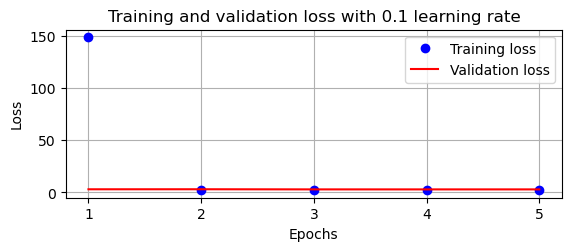

C:\Users\jilla\AppData\Local\Temp\ipykernel_11940\4254919924.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


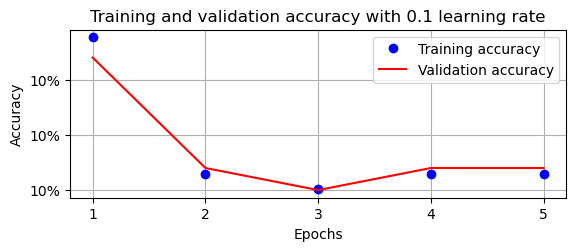

In [9]:
# Plot the accuracy and loss values in the training and validation datasets over increasing epochs.
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

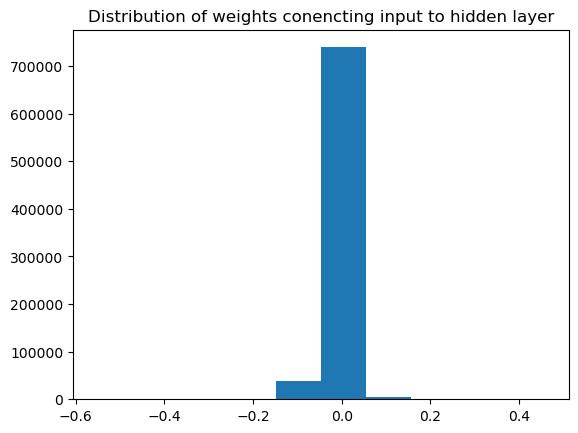

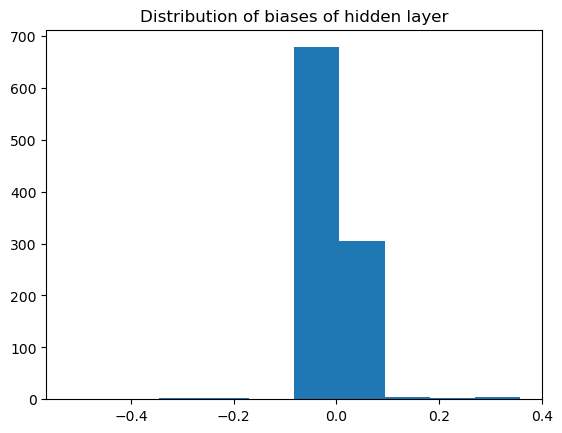

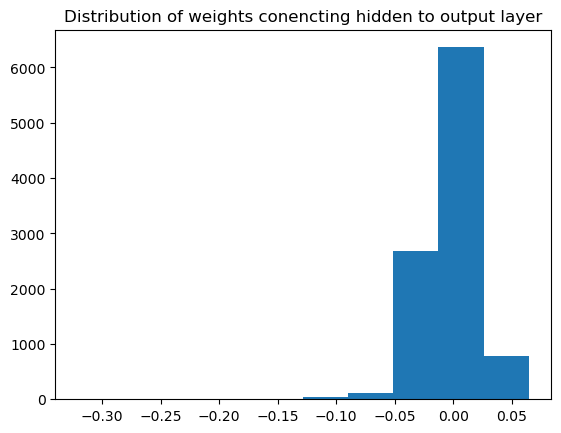

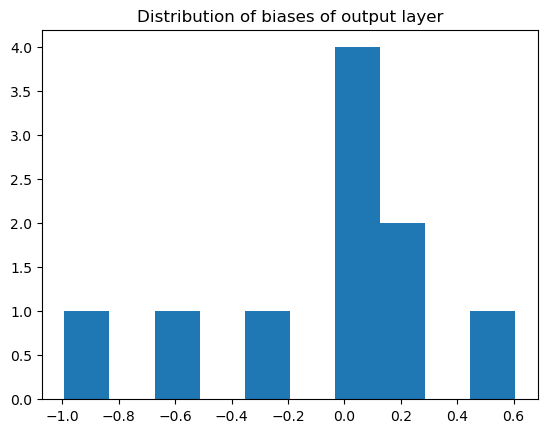

In [14]:
# Plot the distribution of weights connecting the input and hidden layers.
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

The model with unscaled data and a high learning rate cannot be trained.

## Medium Learning Rate of 0.001

In [10]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3) # Setting learning rate to 0.001
    return model, loss_fn, optimizer

In [11]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [12]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


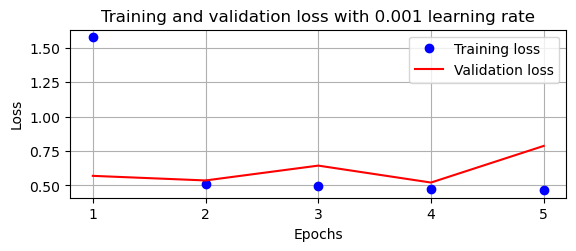

C:\Users\jilla\AppData\Local\Temp\ipykernel_11940\2649727376.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


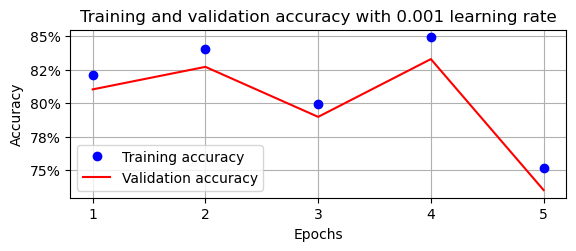

In [13]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

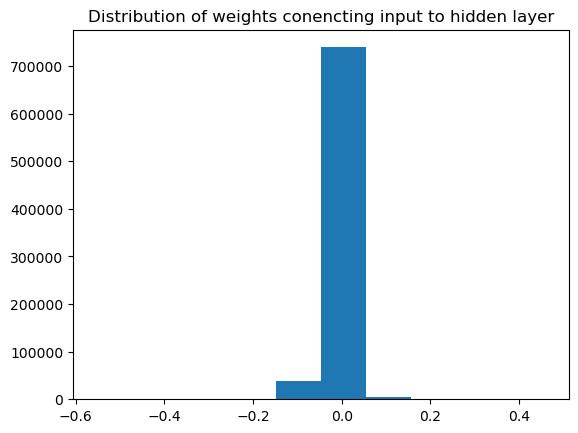

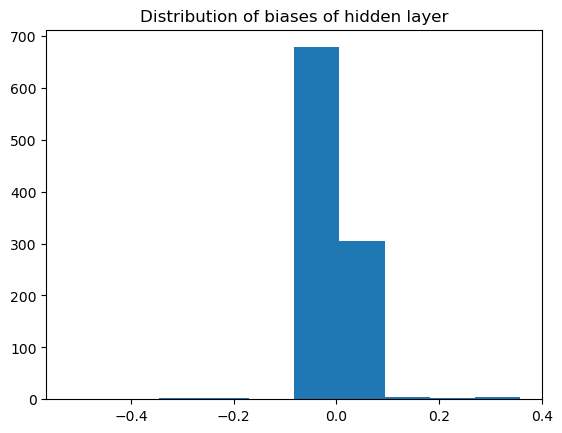

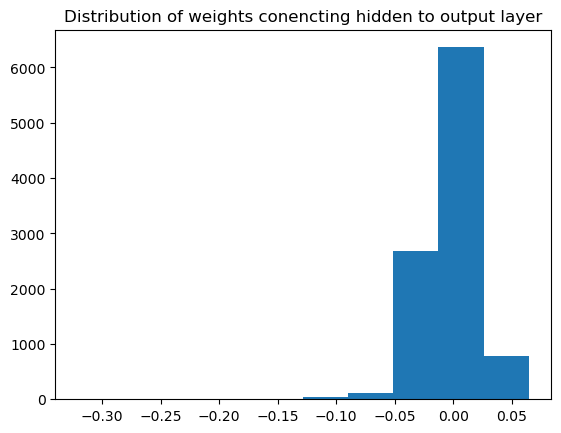

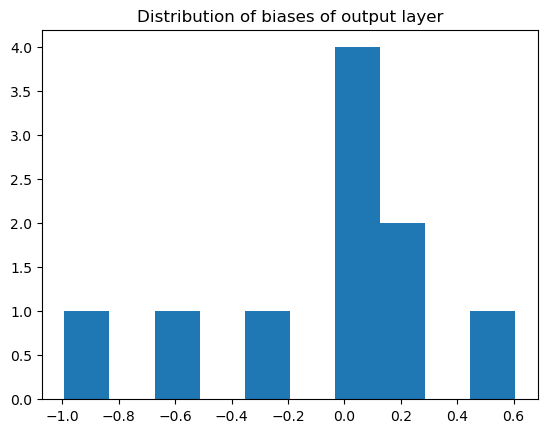

In [15]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

The medium learning rate obtained a lower accuracy using non-scaled data.

## Low Learning Rate of 0.00001

In [16]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-5)
    return model, loss_fn, optimizer 

In [17]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [18]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


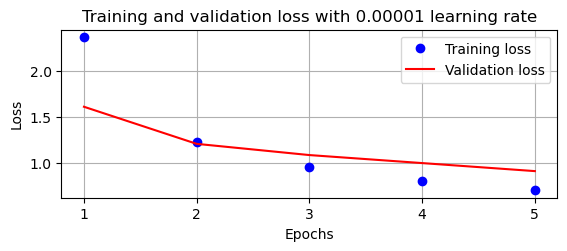

C:\Users\jilla\AppData\Local\Temp\ipykernel_11940\592690014.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


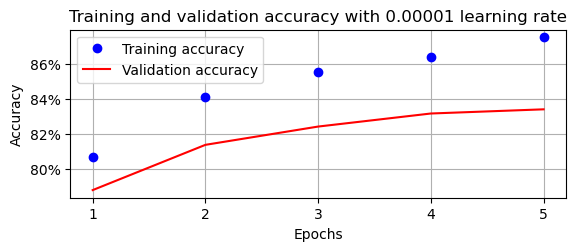

In [19]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

With the learning rate being so low, the model takes longer to achieve an acceptable accuracy. It would take 100 epochs to obtain an 89% accuracy at this learning rate in comparison to 8 epochs at a learning rate of 0.001 to achieve the same. The weight update is much lower when the learning rate is lower, so the gap between the validation and training loss does not widen as fast.

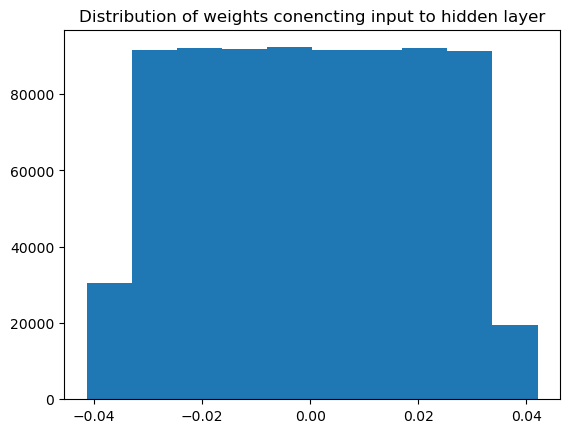

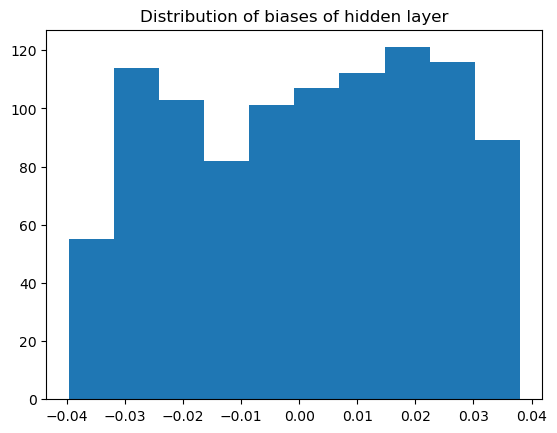

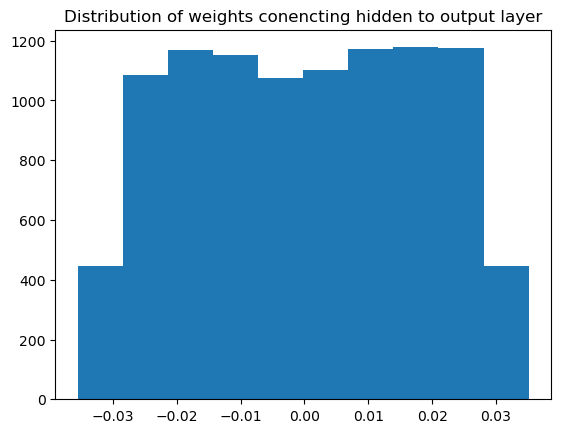

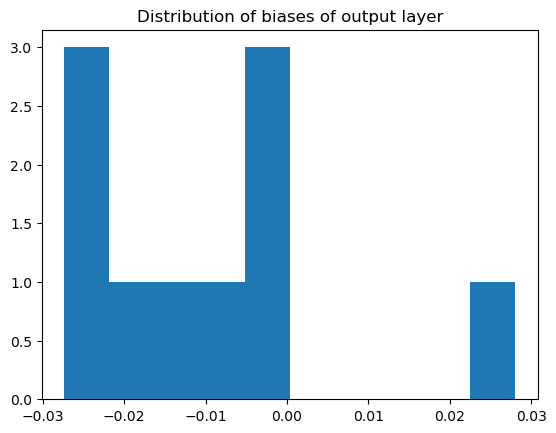

In [20]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

The lower learning rate allowed the model to learn, but easily overfit on the training data. This happened due to the smaller weight range for this model. The learning rate can be reduced automatically when the model begins to overfit.